In [ ]:
#package imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import datasets
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

import re
from sklearn.decomposition import PCA
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
nltk.download('stopwords')
import plotly.graph_objs as plotly  # for interactive plots

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load data
training_data = pd.read_json("train.json")
test_data = pd.read_json("test.json")

stop_words = set(stopwords.words('english'))

In [ ]:
# Separate success/fail sets
pizza = training_data[training_data['requester_received_pizza'] == True]
no_pizza = training_data[training_data['requester_received_pizza'] == False]
no_pizza_short = no_pizza[:len(pizza)]

# Create new dataframe with equal outcomes
new_train = pd.concat([pizza, no_pizza_short], axis = 0)
new_train = new_train.sample(frac=1) # shuffle
#new_train.reset_index()
new_train.reset_index(drop=True, inplace=True)
new_train = new_train.sort_index()
new_train['requester_received_pizza'] = new_train['requester_received_pizza'].astype(int) # boolean to 0/1

# Split data and set the appropriate columns
test_features = test_data.columns
Y = new_train['requester_received_pizza']
X = new_train[training_data.columns[training_data.columns.isin(test_features)]]

# Split for train and validation
val_split = int(len(new_train) * 0.9)
train_data, train_labels = X[:val_split], Y[:val_split]
val_data, val_labels = X[val_split:], Y[val_split:]


# Get only request text
#train_requests = train_data['request_text_edit_aware']
#val_requests = val_data['request_text_edit_aware']

In [ ]:
train_data


,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,t3_j0aex,"Now, I'm not a poor guy. My family makes money...",[request] Healthy food? Fuck that.,608.777731,0.000000,11,0,4,0,8,"[AskReddit, IAmA, atheism, gaming, qwantzparty...",37,81,Raiden1312,1311702230,1311698630
1,N/A,t3_15nuxv,i'm a 22 year old part time college student (a...,"[request] humble request from Sun City/Ruskin, FL",976.870220,0.000000,331,0,11,0,49,"[AdviceAnimals, AskReddit, FlashFlashRevolutio...",673,1319,tieks0,1356847418,1356847418
2,N/A,t3_qpu20,"First world problems here, nothing major.\n\nS...",[Request]Work deadlines + weekend = Fail,418.885590,0.000000,97,0,11,0,16,"[AskReddit, BusinessIntelligence, Charlotte, C...",283,399,ClemsonLaxer,1331349152,1331349152
3,N/A,t3_1d673k,"Hey, guys. I know it's going to sound like kin...",[REQUEST] Art student would love some cheesy g...,134.858727,0.000000,287,0,11,0,47,"[AdviceAnimals, Art, AskReddit, FiftyFifty, Ga...",1625,2397,AgentCodySpanks,1367007187,1367003587
4,N/A,t3_1c60fa,I'm kind of struggling today so If anyone cou...,[Request] Would totally appreciate a pie from ...,41.898137,16.883796,195,8,8,1,20,"[ABraThatFits, AskReddit, BDSMcommunity, Chris...",581,969,phr3shcooki3s,1365723446,1365719846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,N/A,t3_152asi,"Hey all. My wife is away on business tonight,...",[REQUEST] Pennsylvania dad embarassed to ask f...,302.898275,0.000000,502,0,45,0,50,"[AskReddit, Battlefield, Borderlands2, Deathme...",2058,4356,halupki,1355856432,1355856432
1785,N/A,t3_1iv1fe,My dad passed away on July 11th and I've been ...,[Request] California: My dad passed away two w...,471.233553,0.000000,939,0,96,0,75,"[4chan, AdviceAnimals, AnimalRights, AnimalsBe...",14264,62302,SomeGuyWithABoner,1374554490,1374550890
1786,N/A,t3_qc29b,"Just got everything paid off for the month, wh...","[Request] Bills paid, rent due tomorrow, food ...",124.821296,0.000000,75,0,10,0,12,"[AdviceAnimals, AskReddit, Music, Quite, Rando...",1026,7062,biwley,1330558455,1330558455
1787,carseycritter,t3_15htf7,"...and all I have to eat here is banana bread,...",[Request] Living paycheck-to-paycheck...unexpe...,42.300775,0.000000,49,0,5,0,19,"[AskReddit, CFB, CollegeBasketball, Journalism...",458,624,jeffreydonger,1356570822,1356570822


In [ ]:
val_data.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

In [ ]:
val_labels

0      1
1      1
2      1
3      0
4      1
      ..
194    0
195    1
196    1
197    0
198    0
Name: requester_received_pizza, Length: 199, dtype: int64

In [ ]:
stop_words = list(stop_words)

In [ ]:
for word in ['i\'ve', 'i\'m', 'i\'ll', "i'm", "i've", "i'll", 'im',
            'pizza', 'request']:
    stop_words.append(word)

In [ ]:
train_data.columns

Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')

In [ ]:
# Look at fields used in the test data
test_data.columns

Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')

In [ ]:
# from Cornellia demo notebook
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [ ]:
# modified from hw 9
def decode(token_ids):
    """Return a string with the decoded text given a list of token ids."""
    # Try looking up each id in the index, but return '#' (for OOV) if not found.

    key_list = list(token_index.keys())
    value_list = list(token_index.values())

    tokens = []

    for token_id in token_ids:
        if token_id == 0:
            tokens.append('#')
        else:
            position = value_list.index(token_id)
            tokens.append(key_list[position])

    # Connect the string tokens with a space.
    return ' '.join(tokens)


In [ ]:
def create_token_index(requests):
    '''Creates a dictionary for token : token_id'''
    token_index = {'<START>':1,
              '#': 2,
              '<UNUSED>':3}
    count = 4

    for i in range(len(requests)):
        for j in requests[i].split():
            if j not in stop_words:
                if len(j) > 2:
                    if j not in token_index.keys():
                        token_index[j] = count
                        count += 1

    return token_index

In [ ]:
def tokenize(requests):
    '''input list of text to output tokenized list'''
    token_requests = []

    for i in range(len(requests)):
        tokens = []
        for j in requests[i].split():
            if j in token_index:
                tokens.append(token_index[j])
            else:
                tokens.append(2)
        token_requests.append(tokens)

    return token_requests


In [ ]:
# From HW 9
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

In [ ]:
# From HW 9
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

In [ ]:
train_data['request_text_edit_aware'] = train_data['request_text_edit_aware'].apply(preprocessor)

In [ ]:
train_data['request_text_edit_aware']

0       now i m not a poor guy my family makes money w...
1       i m a 22 year old part time college student an...
2       first world problems here nothing major short ...
3       hey guys i know it s going to sound like kind ...
4        i m kind of struggling today so if anyone cou...
                              ...                        
1784    hey all my wife is away on business tonight so...
1785    my dad passed away on july 11th and i ve been ...
1786    just got everything paid off for the month whi...
1787     and all i have to eat here is banana bread wh...
1788    my two roommates and i are out of food and mon...
Name: request_text_edit_aware, Length: 1789, dtype: object

In [ ]:
Y = train_labels

In [ ]:
Y

0       0
1       0
2       1
3       0
4       1
       ..
1784    1
1785    0
1786    0
1787    1
1788    0
Name: requester_received_pizza, Length: 1789, dtype: int64

In [ ]:
requests = train_data['request_text_edit_aware']

In [ ]:
requests.loc[1335]

''

In [ ]:
token_index = create_token_index(requests)

In [ ]:
len(token_index)

7999

In [ ]:
token_requests = tokenize(requests)

In [ ]:
len(token_requests[1])

75

In [ ]:
len(token_requests) == len(requests)

True

In [ ]:
# Verify things are working as intended
print(requests[10])
print(token_requests[10])
print(decode(token_requests[10]))

hey y all just showed back up to campus last night and completely forgot that the food court closes early on friday nights no real money to speak of until financial aid kicks in and i could use food that isn t a vending machine bag of chips shoot once i start getting my housing allowance i ll even return the favor tl dr i m an idiotic sophomore sometimes ;D
[104, 2, 2, 2, 300, 261, 2, 2, 301, 45, 46, 2, 302, 167, 2, 2, 14, 303, 304, 305, 2, 306, 137, 2, 307, 8, 2, 308, 2, 2, 195, 309, 310, 2, 2, 2, 176, 311, 14, 2, 2, 2, 2, 312, 313, 314, 2, 315, 316, 2, 2, 317, 204, 2, 318, 319, 2, 2, 95, 212, 2, 213, 2, 2, 2, 2, 2, 320, 321, 322, 2]
hey # # # showed back # # campus last night # completely forgot # # food court closes early # friday nights # real money # speak # # financial aid kicks # # # could use food # # # # vending machine bag # chips shoot # # start getting # housing allowance # # even return # favor # # # # # idiotic sophomore sometimes #


In [ ]:
token_id_list = list(token_index.values())

In [ ]:
def count_examples(token):
    '''Counts the number of positive and negative examples containing token'''
    pos_count = 0
    neg_count = 0

    # Loop through each request

    for i in range(len(token_requests)):

        if token in token_requests[i]:

            # Add to positive example count
            if Y[i] == True:
                pos_count += 1

            # Add to negative example count
            if Y[i] == False:
                neg_count += 1

    return (pos_count, neg_count)

In [ ]:
count_examples(500)

(8, 8)

In [ ]:
pos_count = []
neg_count = []

for token_id in token_id_list:
    pos,neg = count_examples(token_id)
    pos_count.append(pos)
    neg_count.append(neg)

In [ ]:
d = {
    'word': token_id_list,
    'n_pos': pos_count,
    'n_neg': neg_count
}

In [ ]:
words_df = pd.DataFrame(d)

In [ ]:
clean_df = words_df[words_df.n_pos > 50]
clean_df = clean_df[words_df.n_neg > 50]

In [ ]:
clean_df.sort_values('n_pos', ascending = False)[25:50]

,word,n_pos,n_neg
86,87,143,102
192,193,142,94
369,370,142,98
216,217,133,107
723,724,132,79
173,174,119,95
105,106,115,113
112,113,115,96
135,136,113,80
235,236,112,87


In [ ]:
decode([49])

'divorced'

In [ ]:
padded_token_requests = pad_data(token_requests, 100)

In [59]:
reduced_token_requests = limit_vocab(padded_token_requests, max_token_id=2232)

In [63]:
reduced_one_hot = tf.keras.utils.to_categorical(reduced_token_requests)

In [64]:
len(reduced_one_hot)

1789

In [65]:
X_train = reduced_one_hot
Y_train = Y

In [47]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  #plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [ ]:
def build_onehot_model3(average_over_positions=False):
  """Build a tf.keras model for one-hot data."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for classification
  ))

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=.01),
                metrics=[tf.keras.metrics.BinaryAccuracy()])

  return model

In [67]:
model5 = build_onehot_model3(average_over_positions=False)

Epoch 1/15
28/28 [==============================] - 1s 29ms/step - loss: 0.7067 - binary_accuracy: 0.5316
Epoch 2/15
28/28 [==============================] - 1s 31ms/step - loss: 0.3626 - binary_accuracy: 0.9312
Epoch 3/15
28/28 [==============================] - 1s 33ms/step - loss: 0.2377 - binary_accuracy: 0.9581
Epoch 4/15
28/28 [==============================] - 1s 31ms/step - loss: 0.1793 - binary_accuracy: 0.9765
Epoch 5/15
28/28 [==============================] - 1s 31ms/step - loss: 0.1450 - binary_accuracy: 0.9771
Epoch 6/15
28/28 [==============================] - 1s 29ms/step - loss: 0.1197 - binary_accuracy: 0.9816
Epoch 7/15
28/28 [==============================] - 1s 30ms/step - loss: 0.1022 - binary_accuracy: 0.9849
Epoch 8/15
28/28 [==============================] - 1s 32ms/step - loss: 0.0893 - binary_accuracy: 0.9838
Epoch 9/15
28/28 [==============================] - 1s 30ms/step - loss: 0.0787 - binary_accuracy: 0.9855
Epoch 10/15
28/28 [===========================

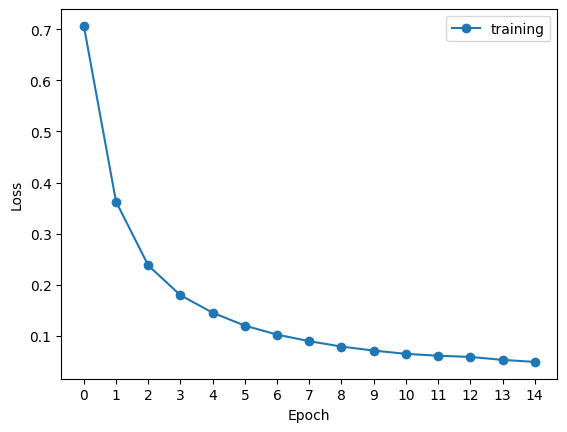

In [68]:
history5 = model5.fit(
  x = X_train,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=15,             # number of passes through the training data
  batch_size=64,        # mini-batch size
   # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history5 = pd.DataFrame(history5.history)
plot_history(history5)

In [69]:
Y_val = val_labels

In [70]:
val_data['request_text_edit_aware'] = val_data['request_text_edit_aware'].apply(preprocessor)

In [71]:
val_requests = val_data['request_text_edit_aware']

In [72]:
val_requests

0      we ve been pretty responsible people my girlfr...
1      just a guy out of money after christmas shoppi...
2      this summer has been pretty rough the last of ...
3      it is that time of the month where bills are d...
4      hello fellow redditors i lost my job earlier t...
                             ...                        
194    my girlfriend and i are both recent college gr...
195    i m as broke as i ve ever been and hungry i m ...
196                                                     
197    so we re having a house show and pizza boxes m...
198    i hurt my hip and can t walk or stand long eno...
Name: request_text_edit_aware, Length: 199, dtype: object

In [73]:
token_index = create_token_index(val_requests)

In [74]:
val_token_requests = tokenize(val_requests)

In [75]:
val_padded_token_requests = pad_data(val_token_requests, 100)
val_reduced_token_requests = limit_vocab(val_padded_token_requests, max_token_id=2232)
val_reduced_one_hot = tf.keras.utils.to_categorical(val_reduced_token_requests)
val_reduced_one_hot.shape
X_val = val_reduced_one_hot


In [76]:
X_val.shape

(199, 100, 2232)

In [77]:
X_train.shape

(1789, 100, 2232)

Epoch 1/15
4/4 [==============================] - 0s 24ms/step - loss: 0.7597 - binary_accuracy: 0.5377
Epoch 2/15
4/4 [==============================] - 0s 24ms/step - loss: 0.3197 - binary_accuracy: 0.8794
Epoch 3/15
4/4 [==============================] - 0s 28ms/step - loss: 0.1257 - binary_accuracy: 0.9799
Epoch 4/15
4/4 [==============================] - 0s 27ms/step - loss: 0.0879 - binary_accuracy: 0.9548
Epoch 5/15
4/4 [==============================] - 0s 21ms/step - loss: 0.0710 - binary_accuracy: 0.9598
Epoch 6/15
4/4 [==============================] - 0s 27ms/step - loss: 0.0420 - binary_accuracy: 0.9899
Epoch 7/15
4/4 [==============================] - 0s 23ms/step - loss: 0.0422 - binary_accuracy: 0.9849
Epoch 8/15
4/4 [==============================] - 0s 26ms/step - loss: 0.0449 - binary_accuracy: 0.9849
Epoch 9/15
4/4 [==============================] - 0s 24ms/step - loss: 0.0374 - binary_accuracy: 0.9849
Epoch 10/15
4/4 [==============================] - 0s 27ms/step 

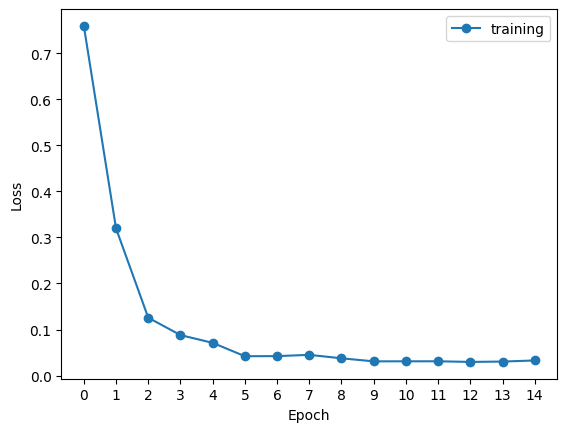

In [78]:
history6 = model5.fit(
  x = X_val,  # one-hot training data
  y = Y_val,          # corresponding binary labels
  epochs=15,             # number of passes through the training data
  batch_size=64,        # mini-batch size
   # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history6 = pd.DataFrame(history6.history)
plot_history(history6)

In [79]:
probabilities = model5.predict(X_val)
threshold = 0.5
binary_predictions = (probabilities > threshold).astype(int)
confusion_matrix(Y_val, binary_predictions)

7/7 [==============================] - 0s 8ms/step


array([[ 96,   2],
       [  0, 101]])

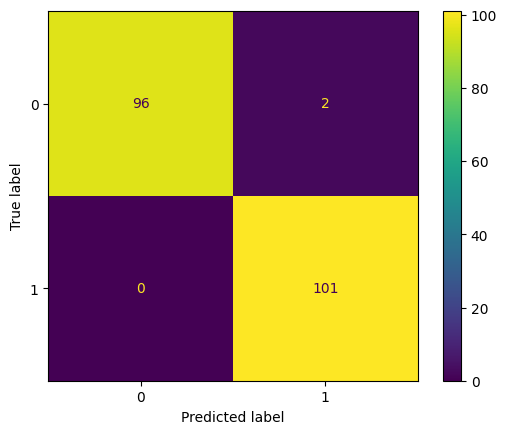

In [80]:


cm = confusion_matrix(Y_val, binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [81]:
# Show the classification report
print(classification_report(Y_val, binary_predictions))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99        98
           1       0.98      1.00      0.99       101

    accuracy                           0.99       199
   macro avg       0.99      0.99      0.99       199
weighted avg       0.99      0.99      0.99       199



In [82]:
test_data['request_text_edit_aware'] = test_data['request_text_edit_aware'].apply(preprocessor)

In [83]:
test_requests = test_data['request_text_edit_aware']

In [84]:
token_index = create_token_index(test_requests)

In [85]:
test_token_requests = tokenize(test_requests)

In [86]:
test_padded_token_requests = pad_data(test_token_requests, 100)

In [87]:
test_reduced_token_requests = limit_vocab(test_padded_token_requests, max_token_id=2232)

In [88]:
test_reduced_one_hot = tf.keras.utils.to_categorical(test_reduced_token_requests)

In [89]:
test_reduced_one_hot.shape

(1631, 100, 2232)

In [90]:
Y2 = training_data['requester_received_pizza']

In [91]:
X_test = test_reduced_one_hot
Y_test = Y2

In [92]:
X_test.shape

(1631, 100, 2232)

In [93]:
test_probabilities = model5.predict(X_test)
threshold = 0.5
test_binary_predictions = (test_probabilities > threshold).astype(int)

51/51 [==============================] - 1s 12ms/step


In [94]:
predictions = model5.predict(X_test)

51/51 [==============================] - 0s 8ms/step


In [95]:
test_binary_predictions

array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [97]:
# function to create dataframe
def get_submission_csv(predictions):
    test_ids = test_data['request_id']

    d = {'request_id': test_ids,
    'requester_received_pizza': predictions}

    df = pd.DataFrame(data=d)
    df['requester_received_pizza'] = df['requester_received_pizza'].astype(int)

    return df

In [98]:
# flatten predictions
test_predictions_flat = test_binary_predictions.flatten()

# create dataframe using function
test_predictions_df = get_submission_csv(test_predictions_flat)

# create csv from dataframe
test_predictions_df.to_csv('one_hot_model_predictions.csv', index=False)

In [99]:
test_predictions_df['requester_received_pizza'].value_counts()

0    974
1    657
Name: requester_received_pizza, dtype: int64

In [100]:
test_predictions_df[test_predictions_df['requester_received_pizza'] == 1]

,request_id,requester_received_pizza
1,t3_1mfqi0,1
2,t3_lclka,1
5,t3_pvojb,1
8,t3_1lg6u2,1
9,t3_1b0mtx,1
...,...,...
1616,t3_10cy64,1
1623,t3_1cn0h3,1
1627,t3_11wza2,1
1629,t3_nys7g,1
